In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


data = pd.read_csv('051622 Sample 1.txt', delimiter='\t', header=None)
pv = data[1].to_numpy()
T = data[0][1] - data[0][0]
timestamp = np.arange(start = 0, stop = len(pv)*T, step = T)

(0.0, 0.16)

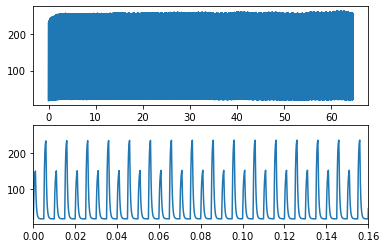

In [2]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(timestamp,pv)
ax2.plot(timestamp,pv)
ax2.set_xlim(0, 1600*T)

array([233.7344, 234.1563, 234.2656, ..., 258.1406, 258.0156, 258.0938])

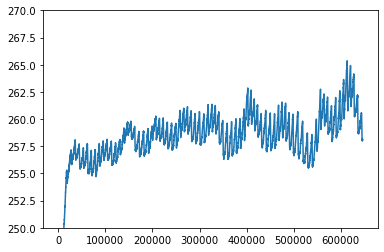

In [66]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import numpy as np

peaks, _ = find_peaks(pv, height=200)
nir = pv[peaks]
plt.plot(peaks, nir)
plt.ylim(250, 270)

#store high peak values
a = np.array(nir)
high_peak = a[np.logical_and(a >= 220, a <= 270)]
high_peak



array([150.1406, 150.7969, 150.8906, ..., 161.5781, 161.7344, 161.7031])

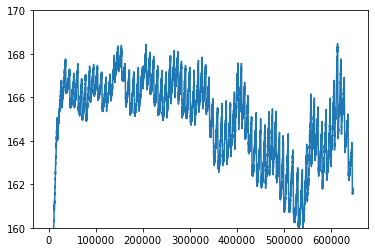

In [64]:
import numpy as np
peaks, _ = find_peaks(pv, height=(150,200))
nir = pv[peaks]
plt.plot(peaks, nir)
plt.ylim(160, 170)

#store low peak values
a = np.array(nir)
low_peak = a[np.logical_and(a >= 140, a <= 170)]
low_peak



/var/folders/l7/h3nhqt8n2rl5hxy9gsqrk58r0000gn/T/ipykernel_17319/2873084161.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
/var/folders/l7/h3nhqt8n2rl5hxy9gsqrk58r0000gn/T/ipykernel_17319/2873084161.py:14: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('lowpeak.csv', header=0,index_col=0, squeeze=True)


<AxesSubplot:>

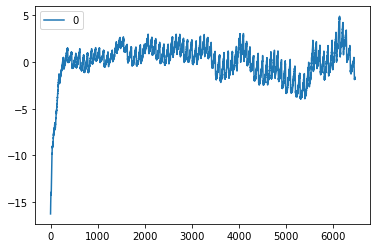

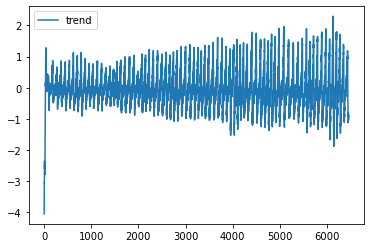

In [67]:
from matplotlib import pyplot
from pandas import read_csv
from pandas import datetime
import pandas as pd
from scipy import signal

# detrend the low_peak series
data_dict = {'x': peaks,
             'y': low_peak
}
data_dict
data = pd.DataFrame(data_dict)
data.to_csv("lowpeak.csv")
series = read_csv('lowpeak.csv', header=0,index_col=0, squeeze=True)

#remove linear trend
detrended = signal.detrend(series.y)
detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

#remove seasonal trend
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(series.y, model='additive', extrapolate_trend='freq',period=int(len(series.y)/100))
detrended = series.y.values - res.trend

detrended_df = pd.DataFrame(detrended)
detrended_df.plot()


/var/folders/l7/h3nhqt8n2rl5hxy9gsqrk58r0000gn/T/ipykernel_17319/3990891437.py:8: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('lowpeak.csv', header=0,index_col=0, squeeze=True)


<AxesSubplot:>

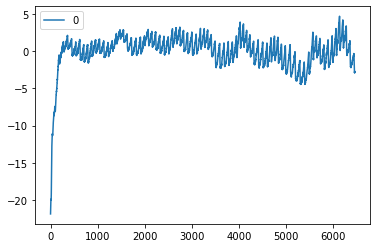

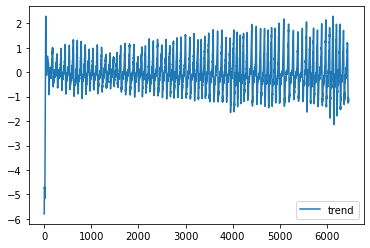

In [68]:

# detrend the high_peak series
data_dict = {'x': peaks,
             'y': high_peak
}
data_dict
data = pd.DataFrame(data_dict)
data.to_csv("lowpeak.csv")
series = read_csv('lowpeak.csv', header=0,index_col=0, squeeze=True)

#remove linear trend
detrended = signal.detrend(series.y)
detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

#remove seasonal trend
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(series.y, model='additive', extrapolate_trend='freq',period=int(len(series.y)/100))
detrended = series.y.values - res.trend

detrended_df = pd.DataFrame(detrended)
detrended_df.plot()
